# Examples of troubleshooting for mixed-polyhedral mesh

We use Coweeta watershed as an example

In [1]:
## Importing all the package needed to run the watershed workflow

# silence shapely2.0 and crs WKT warnings
import warnings
warnings.filterwarnings('ignore')

# standard python packages
import os,sys
import numpy as np
import pandas
from matplotlib import pyplot as plt
import logging
import pandas as pd
import copy
import shapely

# watereshed workflow packages
import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.densification
import watershed_workflow.condition
import watershed_workflow.regions

# set the verbosity of logging
watershed_workflow.ui.setup_logging(1,None)


In [9]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
coweeta_shapefile = '../Coweeta_data/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'
modis_name = None

figsize = (6,6)
figsize_3d = (8,6)

# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
simplify = 60 # length scale to target average edge
ignore_small_rivers = 2
prune_by_area_fraction = 0.01

# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

In [10]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Helper Functions

In [11]:
from shapely.geometry import LineString
def trim_linestring(linestring, fraction, from_start=True):
    total_length = linestring.length
    trim_length = total_length * fraction

    if from_start:
        # Trimming from the start
        current_length = 0
        for i, point in enumerate(linestring.coords[:-1]):
            segment = LineString([point, linestring.coords[i + 1]])
            current_length += segment.length
            if current_length >= trim_length:
                return LineString([segment.interpolate(current_length - trim_length)] + linestring.coords[i + 1:])

    else:
        # Trimming from the end (original method)
        trimmed_length = total_length - trim_length
        current_length = 0
        for i, point in enumerate(linestring.coords[:-1]):
            segment = LineString([point, linestring.coords[i + 1]])
            current_length += segment.length
            if current_length >= trimmed_length:
                return LineString(linestring.coords[:i + 1] + [segment.interpolate(trimmed_length - (current_length - segment.length))])

    return linestring


## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [12]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()


#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster('../Coweeta_data/input_data/land_cover/land_cover.tif')
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS('../Coweeta_data/input_data/GLHYMPS/GLHYMPS.shp')
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('../Coweeta_data/input_data/DTB/DTB.tif')
watershed_workflow.source_list.log_sources(sources)

2023-12-10 13:47:57,186 - root - INFO: Using sources:
2023-12-10 13:47:57,186 - root - INFO: --------------
2023-12-10 13:47:57,187 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-12-10 13:47:57,187 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-12-10 13:47:57,188 - root - INFO: DEM: National Elevation Dataset (NED)
2023-12-10 13:47:57,189 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-12-10 13:47:57,189 - root - INFO: geologic structure: ../Coweeta_data/input_data/GLHYMPS/GLHYMPS.shp
2023-12-10 13:47:57,189 - root - INFO: land cover: raster
2023-12-10 13:47:57,190 - root - INFO: lai: MODIS
2023-12-10 13:47:57,190 - root - INFO: soil thickness: None
2023-12-10 13:47:57,190 - root - INFO: meteorology: DayMet 1km
2023-12-10 13:47:57,191 - root - INFO: depth to bedrock: raster


## Generate Surface Mesh

### Get HUCs

In [13]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

# note that watershed is now a SplitHUCs object, as described above
print(watershed)


2023-12-10 13:47:57,977 - root - INFO: 
2023-12-10 13:47:57,978 - root - INFO: Loading shapes
2023-12-10 13:47:57,979 - root - INFO: ------------------------------
2023-12-10 13:47:57,979 - root - INFO: Loading file: '../Coweeta_data/input_data/coweeta_basin.shp'
2023-12-10 13:47:58,001 - root - INFO: ... found 1 shapes
2023-12-10 13:47:58,001 - root - INFO: Converting to shapely
2023-12-10 13:47:58,002 - root - INFO:  ... done
2023-12-10 13:47:58,005 - root - INFO: Converting to requested CRS
2023-12-10 13:47:58,014 - root - INFO:  ... done
2023-12-10 13:47:58,015 - root - INFO: Removing holes on 1 polygons
2023-12-10 13:47:58,016 - root - INFO:   -- removed interior
2023-12-10 13:47:58,017 - root - INFO:   -- union
2023-12-10 13:47:58,018 - root - INFO: Parsing 1 components for holes
2023-12-10 13:47:58,019 - root - INFO:   -- complete


### Get Rivers 

In [17]:
import ipympl
%matplotlib ipympl

In [18]:
# load pickle files of already created rivers
import pickle
with open("./data/pickled_data/coweeta_rivers_pickle", 'rb') as handle:
    rivers = pickle.load(handle)

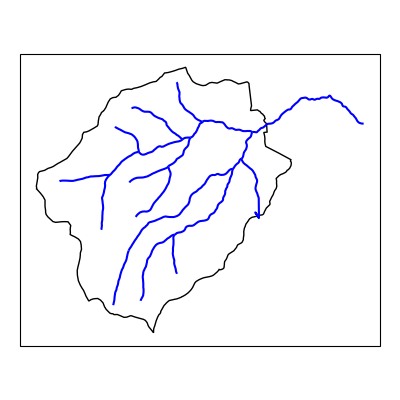

In [20]:
# quick look at rivers and watershed boundary
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)

plt.show()

### Simplify and Redensify

In [21]:
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed)

# simplifying
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            merge_tol=0.7*simplify, snap_tol=0.5*simplify, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers]
watershed_simplified=copy.deepcopy(watershed)

print('number of reaches in original', len(rivers_orig[0]), 'number of reaches in simplified', len(rivers[0]))

2023-12-10 13:49:06,347 - root - INFO: 
2023-12-10 13:49:06,347 - root - INFO: Simplifying
2023-12-10 13:49:06,348 - root - INFO: ------------------------------
2023-12-10 13:49:06,349 - root - INFO: Simplifying rivers
2023-12-10 13:49:06,357 - root - INFO: Simplifying HUCs
2023-12-10 13:49:06,358 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2023-12-10 13:49:06,360 - root - INFO:   snapping polygon segment boundaries to river endpoints
2023-12-10 13:49:06,363 - root - INFO:   snapping river endpoints to the polygon
2023-12-10 13:49:06,371 - root - INFO:     snapped river: (1446485.9598044618, -648038.6404259473) to (1446473.7321661003, -648003.3717252921)
2023-12-10 13:49:06,375 - root - INFO:   cutting at crossings
2023-12-10 13:49:06,376 - root - INFO: intersection found
2023-12-10 13:49:06,378 - root - INFO:   - cutting reach at external boundary of HUCs:
2023-12-10 13:49:06,379 - root - INFO:       split HUC boundary seg into 2 pieces
2023-12-10 13:49:06,379 - ro

Dual/multiple section: type = <class 'shapely.geometry.multipoint.MultiPoint'>
 point = MULTIPOINT (1446465.099168299 -648006.3647806961, 1446473.7321661003 -648003.3717252921)


CutError: Dual/multiple intersection in a single seg... ugh!  Intersection is of type '<class 'shapely.geometry.multipoint.MultiPoint'>'

This error is because a reach has two intersections with the watershed boundary, a case of inconsistent data of mapped flowlines for river and watershed boundary. As a remedy, we could either trim the river or move the river or watershed boundary segment. 

Here we will trim the river.

In [22]:
# revert to original river
rivers =[river.deepcopy() for river in rivers_orig]

In [ ]:
# # plot

# fig, ax = watershed_workflow.plot.get_ax(crs)
# watershed_workflow.plot.hucs(watershed, crs, 'k', ax)

# reaches = [r.getSegment() for river in rivers for r in river.preOrder()]
# colors = watershed_workflow.colors.enumerated_colors(len(reaches))
# lc = watershed_workflow.plot.shplys(reaches, crs, colors, ax=ax, marker='x', picker=True)

# labeler = watershed_workflow.plot.Labeler(ax, lc, reaches, format="ID: {ID}, HY: {HydrologicSequence}, DIV: {DivergenceCode}, AREA: {ContributingAreaSqKm}")

# def onpick1(event):
#     labeler.update(event)
# fig.canvas.mpl_connect('pick_event', onpick1)

# plt.show()


We can get the problematic node using either node ID (if the dataset is from NHDPlus, this is NHD_ID). We also have widgets that display node id on hovering over nodes. 

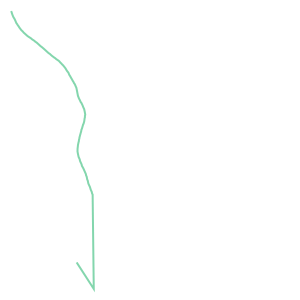

In [23]:
## get the problematic node
river= rivers[0]
node_id = '25000400108019'
node = river.getNode(node_id)
node.segment

In [24]:
trimmed_reach_segment = trim_linestring(node.segment, 0.25, from_start=True) # Trims from start


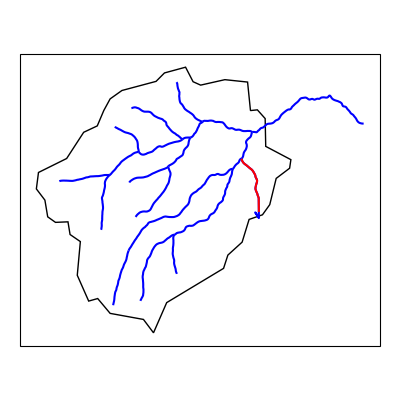

In [25]:
# let's have a loot at trimmed node
# quick look at rivers and watershed boundary
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
watershed_workflow.plot.shply(trimmed_reach_segment, crs, 'r', ax)
plt.show()

In [26]:
# assign the edited reach segment back to the node
node.segment = trimmed_reach_segment

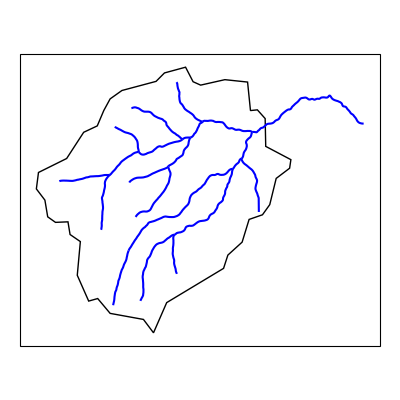

In [27]:
# quick look at rivers and watershed boundary after editing river
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
plt.show()

In [28]:
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed)

# simplifying
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            merge_tol=0.7*simplify, snap_tol=0.5*simplify, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers]
watershed_simplified=copy.deepcopy(watershed)

print('number of reaches in original', len(rivers_orig[0]), 'number of reaches in simplified', len(rivers[0]))

2023-12-10 13:49:34,553 - root - INFO: 
2023-12-10 13:49:34,554 - root - INFO: Simplifying
2023-12-10 13:49:34,554 - root - INFO: ------------------------------
2023-12-10 13:49:34,555 - root - INFO: Simplifying rivers
2023-12-10 13:49:34,560 - root - INFO: Simplifying HUCs
2023-12-10 13:49:34,561 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2023-12-10 13:49:34,562 - root - INFO:   snapping polygon segment boundaries to river endpoints
2023-12-10 13:49:34,564 - root - INFO:   snapping river endpoints to the polygon
2023-12-10 13:49:34,577 - root - INFO:   cutting at crossings
2023-12-10 13:49:34,578 - root - INFO: intersection found
2023-12-10 13:49:34,579 - root - INFO:   - cutting reach at external boundary of HUCs:
2023-12-10 13:49:34,579 - root - INFO:       split HUC boundary seg into 1 pieces
2023-12-10 13:49:34,580 - root - INFO:       split reach seg into 2 pieces
2023-12-10 13:49:34,581 - root - INFO: intersection found
2023-12-10 13:49:34,583 - root - INFO:

number of reaches in original 22 number of reaches in simplified 22


In [29]:
%matplotlib inline

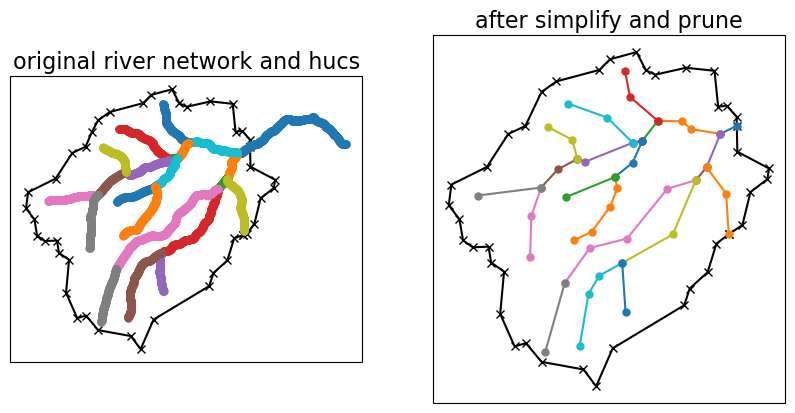

In [31]:
# let's see what changed between original and simplified river

fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(10,10))

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy
        axs[1].plot(x,y,'-o',markersize=5)